En primer lugar, importamos las bibliotecas necesarias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, make_scorer, fbeta_score
from sklearn.tree import plot_tree

Configuramos una semilla aleatoria para reproducibilidad.

In [2]:
np.random.seed(123)

Cargamos el dataset que contiene indicadores de salud y diagnósticos de diabetes.

In [3]:
data = pd.read_csv('../data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']

Dividimos los datos en conjuntos de entrenamiento y prueba, en proporción 80% -20%:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

Creamos un pipeline para Random Forest:

In [5]:
def create_rf_pipeline():

    return Pipeline([
        ('rf', RandomForestClassifier(random_state=123, n_jobs=-1))
    ])

Definimos la grilla:

In [6]:
def get_param_grid():

    return {
        'rf__n_estimators': [150, 200, 250],       # Descartados [100, 300, 400],
        'rf__min_samples_split': [2, 3, 5, 10],   
        'rf__min_samples_leaf': [3, 5],                   
        'rf__max_features': ['sqrt'],              # Descartados ['log2', None],
        'rf__bootstrap': [True],                   # Valor por defecto (Descartada opción False, donde se se utiliza todo el conjunto de datos para construir cada árbol)
        'rf__criterion': ['entropy']               # Descartado ['gini']
    }

Configuramos GridSearch y aplicamos validación cruzada estratificada. Además, vamos a utilizar los scoring roc_auc, accuracy, recall y f2. Esta última métrica prioriza el recall, en comparación a f1-score, y será la utilizada para seleccionar el mejor modelo. Esto se debe a que, al ser un caso clínico, es preferible identificar correctamente la mayor cantidad posible de pacientes con diabetes, incluso si esto resulta en un pequeño incremento de los falsos positivos.

In [7]:
grid_search = GridSearchCV(
    estimator=create_rf_pipeline(),
    param_grid=get_param_grid(),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    scoring={
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'recall': 'recall',
        'f2': make_scorer(fbeta_score, beta=2)
    },
    refit='f2',
    n_jobs=-1,
    verbose=1
)


Recorremos toda la grilla, aplicando paralelización para acelerar el proceso:

In [8]:
grid_search.fit(X_train, y_train)
    
# Obtenemos el pipeline con el mejor modelo.
best_pipeline = grid_search.best_estimator_

# Asimismo, obtenemos el RandomForestClassifier del pipeline. 
# Esto lo vamos a utilizar más adelante para representar un trozo del árbol de decisión.
rf_classifier = best_pipeline.named_steps['rf']

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Finalmente, imprimimos las soluciones obtenidas acordes al umbral óptimo y las métricas utilidas anteriormente:

In [9]:
def find_optimal_threshold(fpr, tpr, thresholds, min_recall=0.85):
    for i, threshold in enumerate(thresholds):
        if tpr[i] >= min_recall:
            return threshold
    return thresholds[np.argmax(tpr - fpr)]


Best parameters: {'rf__bootstrap': True, 'rf__criterion': 'entropy', 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 150}
Best cross-validation accuracy: 0.7803164862949645

Optimal Threshold: 0.44

Final Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

         0.0       0.81      0.65      0.72      7070
         1.0       0.71      0.85      0.77      7069

    accuracy                           0.75     14139
   macro avg       0.76      0.75      0.75     14139
weighted avg       0.76      0.75      0.75     14139


Test set accuracy with Optimal Threshold: 0.7519


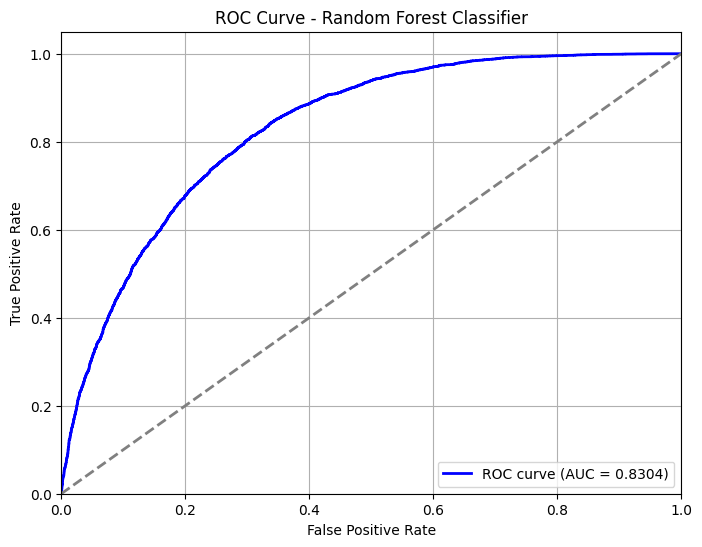


Confusion Matrix with Optimal Threshold:


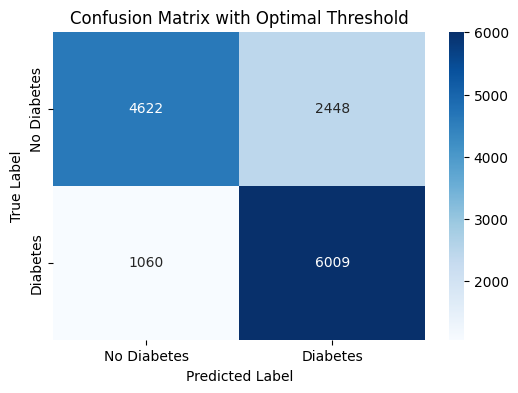

In [10]:
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Realizamos predicciones en el conjunto de prueba
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

# Calculamos la curva ROC y obtenemos los verdaderos y falsos positivos (TPR y FPR) junto con los umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Identificamos el umbral óptimo basándonos en la curva ROC
optimal_threshold = find_optimal_threshold(fpr, tpr, thresholds)
print(f"\nOptimal Threshold: {optimal_threshold:.2f}")

# Ajustamos las predicciones utilizando el umbral óptimo
y_pred_final = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluamos las métricas del modelo
print("\nFinal Classification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_final))

# Calculamos el accuracy del conjunto de prueba con el umbral óptimo
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f"\nTest set accuracy with Optimal Threshold: {accuracy_final:.4f}")

# Representamos la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Finalmente, calculamos matriz de confusión
cm_final = confusion_matrix(y_test, y_pred_final)
print("\nConfusion Matrix with Optimal Threshold:")
plt.figure(figsize=(6, 4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix with Optimal Threshold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Una vez analizada la solución, podemos concluir:
- ROC AUC: 0.8304, lo que indica una mejor capacidad para distinguir entre las clases.
- Accuracy: 0.7519, reflejando un aumento en la proporción de predicciones correctas respecto a KNN

Random Forest logró, aunque levemente, un mejor rendimiento general en comparación con KNN. Asimismo, gracias al uso de F2-Score como métrica predominante (dando más peso al recall que a la precisión), se ha priorizado la capacidad del modelo para detectar la mayor cantidad de casos positivos posibles (personas con diabetes), a cambio de un incremento en los falsos positivos. Esto se debe a que un falso negativo puede tener consecuencias serias en la práctica clínica, ya que el paciente no recibirá tratamiento ni seguimiento médico adecuado, derivando en complicaciones como problemas cardíacos, daño renal, ceguera o incluso la muerte. Por otro lado, un falso positivo genera una situación mucho menos grave: el paciente será sometido a pruebas adicionales para descartar la enfermedad, pero no compromete directamente la salud del paciente.

Adicionalmente, extraemos uno de los árboles de decisión a partir del clasificador y lo visualizamos.

Nota: Se ha ajustado la profundidad del árbol para mayor nitidez del texto en las etiquetas.

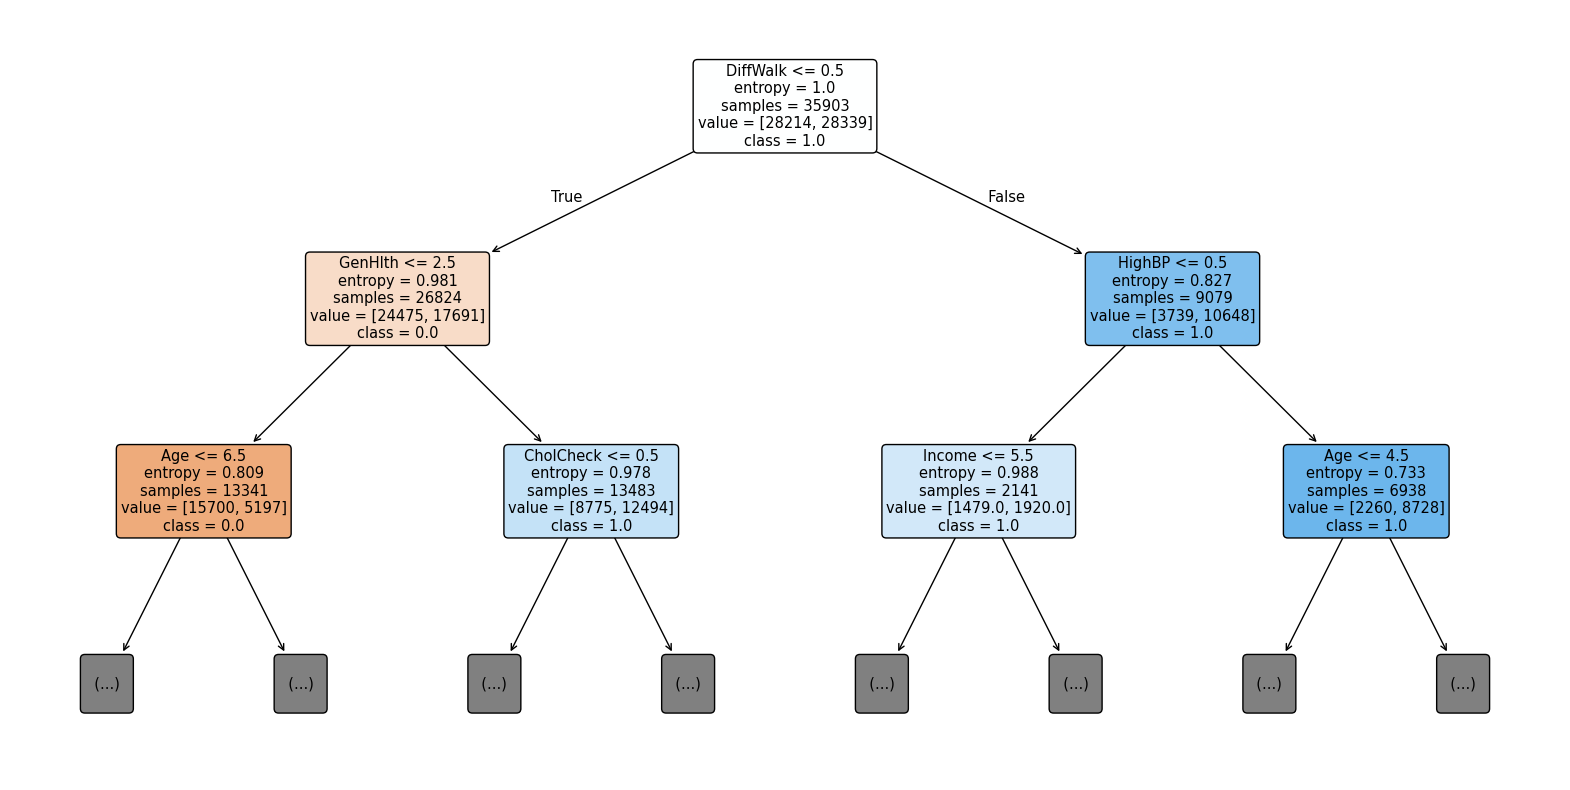

In [11]:
individual_tree = rf_classifier.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(individual_tree, 
          feature_names=X.columns, 
          class_names=y.unique().astype(str), 
          filled=True, 
          rounded=True,
          max_depth=2)
plt.show()
